In [1]:
# import librerie
import os

import torch
import torchvision
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


from avalanche.benchmarks.classic import SplitMNIST
from avalanche.benchmarks.datasets import MNIST

from avalanche.models import SimpleMLP
from avalanche.training import Naive

from pytorch_ood.detector import OpenMax
from pytorch_ood.utils import OODMetrics

import numpy as np
import seaborn as sns



/Users/marcocosseddu/opt/miniconda3/envs/tesi_env1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'AUROC': 0.0,
 'AUPR-IN': 0.1666666716337204,
 'AUPR-OUT': 0.4166666865348816,
 'FPR95TPR': 1.0}

In [15]:
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
from pytorch_ood.utils import OODMetrics
from pytorch_ood.dataset.img import Textures
from pytorch_ood.utils import ToUnknown
from pytorch_ood.model import WideResNet
from avalanche.models import SimpleMLP
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(
            64, 10
        )  # Output size matches the number of desired classes

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input images
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def filter_by_class(dataset, classes):
    # Find the indices of samples belonging to the specified classes
    indices = [i for i, (_, label) in enumerate(dataset) if label in classes]

    # Create a subset with the specified indices
    subset = Subset(dataset, indices)
    return subset

def train_model():

    # Load the MNIST dataset
    trans = transforms.ToTensor()

    mnist_train = MNIST(root="./data", train=True, download=True, transform=trans)
    mnist_test = MNIST(root="./data", train=False, download=True, transform=trans)

    desired_classes_test = [4, 5, 6, 7]
    filtered_train = filter_by_class(mnist_train, [0, 1, 2, 3])
    filtered_test = filter_by_class(mnist_test, desired_classes_test)
    ood_dataset = Subset(
    mnist_test,
    [i for i, (_, label) in enumerate(mnist_test) if label not in desired_classes_test],
    )

    # Combine filtered test dataset with OOD dataset
    combined_test_dataset = ConcatDataset([filtered_test, ood_dataset])

    # Create data loaders
    train_loader = DataLoader(filtered_train, batch_size=64, shuffle=True)
    test_loader = DataLoader(combined_test_dataset, batch_size=64, shuffle=True)

    # model = SimpleNN()
    model = SimpleMLP()

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            running_loss += loss.item()

        # Print average loss per epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")
    return model, train_loader, test_loader

In [41]:
from pytorch_ood.detector import OpenMax
from pytorch_ood.detector import EnergyBased
import numpy as np
import pandas as pd

# Define the OpenMax detector
tailsize = 100
alpha = 20
euclid_weight = [0.5, 0.6]


def calculate_best_params(ragg_per_label):
    OOD_score = ragg_per_label['ood_score'].iloc[4:].mean()
    return OOD_score

def best_params(model, train_loader, test_loader):
    
    params_df = pd.DataFrame(columns=["tailsize","alpha","euclid"])
    diff_buffer = []
    detector_buffer = []
    for i in range(0,tailsize,10):
        for j in range(0,alpha,5):
            for z in euclid_weight:
                params_df = params_df._append({
                    "tailsize":i,
                    "alpha":j,
                    "euclid":z
                }, ignore_index=True)
                detector = OpenMax(model, tailsize=i, alpha=j, euclid_weight=z)
                # Fit the detector on the training data
                detector.fit(train_loader)
                metrics_df = pd.DataFrame(columns=["ood_score", "label"])
                # Evaluate the model using the test_loader
                for x, y in test_loader:
                    for i in range(len(x)):
                        ood_score_k = detector.predict(x[i : i + 1])
                        ood_score_k = ood_score_k.detach().numpy()[0]
                        new_row = {"ood_score": ood_score_k, "label": y[i].item()}
                        metrics_df = metrics_df._append(new_row, ignore_index=True)
                # Save the result of the detector
                raggruppamento_per_label = metrics_df.groupby('label').mean()
                diff = calculate_best_params(raggruppamento_per_label)
                diff_buffer.append(diff)
                detector_buffer.append(detector)

    idx = np.argmax(diff_buffer)
    best_detector = detector_buffer[idx]
    best_params = params_df.iloc[idx]
    print("maximum difference between the avareges: ", diff_buffer[idx])


    return best_detector, best_params

model, train_loader, test_loader = train_model()
best_detector, best_params = best_params(model, train_loader, test_loader)

Epoch [1/10], Loss: 0.15120114325678086
Epoch [2/10], Loss: 0.05881005226338441
Epoch [3/10], Loss: 0.0425615698515464
Epoch [4/10], Loss: 0.0327953639598467
Epoch [5/10], Loss: 0.02729588660690693
Epoch [6/10], Loss: 0.02194689477164267
Epoch [7/10], Loss: 0.01768060166130651
Epoch [8/10], Loss: 0.014785119906214946
Epoch [9/10], Loss: 0.014944196197168795
Epoch [10/10], Loss: 0.01130962696363963


/var/folders/fr/kb5lqx_52snbc2w092m1_ncr0000gn/T/ipykernel_3186/2697675085.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  params_df = params_df._append({
/var/folders/fr/kb5lqx_52snbc2w092m1_ncr0000gn/T/ipykernel_3186/2697675085.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = metrics_df._append(new_row, ignore_index=True)
/var/folders/fr/kb5lqx_52snbc2w092m1_ncr0000gn/T/ipykernel_3186/2697675085.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or a

maximum difference between the avareges:  0.0176747255320513


/var/folders/fr/kb5lqx_52snbc2w092m1_ncr0000gn/T/ipykernel_3186/2856495842.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = metrics_df._append(new_row, ignore_index=True)


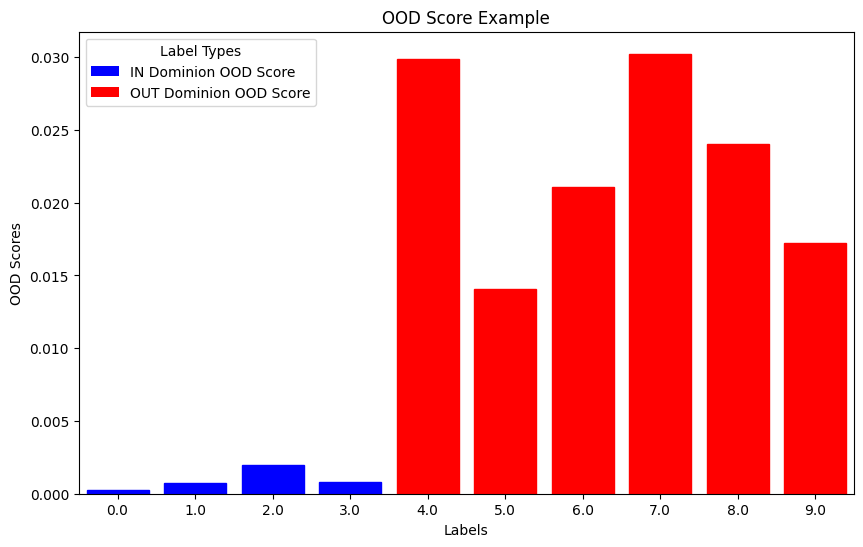

In [33]:
def plot_OOD_scores(best_detector):
    metrics_df = pd.DataFrame(columns=["ood_score", "label"])
    # Evaluate the model using the test_loader
    for x, y in test_loader:
        for i in range(len(x)):
            ood_score_k = best_detector.predict(x[i : i + 1])
            ood_score_k = ood_score_k.detach().numpy()[0]
            new_row = {"ood_score": ood_score_k, "label": y[i].item()}
            metrics_df = metrics_df._append(new_row, ignore_index=True)

    # Save the result of the detector
    raggruppamento_per_label = metrics_df.groupby("label", as_index=False).mean()

    plt.figure(figsize=(10, 6))

    # Create a bar plot
    barplot = sns.barplot(x="label", y="ood_score", data=raggruppamento_per_label)

    # Additional customization
    plt.title("OOD Score Example")
    plt.xlabel("Labels")
    plt.ylabel("OOD Scores")
    # Change the bar colors based on label condition
    for p in barplot.patches:
        if (
            p.get_x() + 1 >= 4 and p.get_x() + 1 <= 10
        ):  # Adjusting the range based on your labels
            p.set_color("red")
        else:
            p.set_color("blue")  # Set to the default or another color if needed
    legend_elements = [
        Patch(facecolor="blue", label="IN Dominion OOD Score"),
        Patch(facecolor="red", label="OUT Dominion OOD Score"),
    ]
    plt.legend(handles=legend_elements, title="Label Types")
    plt.show()


plot_OOD_scores(best_detector)

In [172]:

# Define OODMetrics for evaluation
metrics = OODMetrics(mode="classification")
ood_scores = torch.tensor([])
metrics_df = pd.DataFrame(columns=["ood_score", "label"])
# Evaluate the model using the test_loader
for x, y in test_loader:
    for i in range(len(x)):
        ood_score_k = best_detector.predict(x[i : i + 1])
        ood_score_k = ood_score_k.detach().numpy()[0]
        new_row = {"ood_score": ood_score_k, "label": y[i].item()}
        metrics_df = metrics_df._append(new_row, ignore_index=True)
# Save the result of the detector
raggruppamento_per_label = metrics_df.groupby("label").mean()
raggruppamento_per_label

/var/folders/fr/kb5lqx_52snbc2w092m1_ncr0000gn/T/ipykernel_67002/1925184846.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = metrics_df._append(new_row, ignore_index=True)


,ood_score
label,
0.0,0.007283
1.0,0.003152
2.0,0.007315
3.0,0.005115
4.0,0.055974
5.0,0.024469
6.0,0.037573
7.0,0.050322
8.0,0.027410


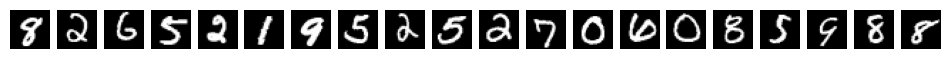

Sample labels: [8, 2, 6, 5, 2, 1, 9, 5, 2, 5, 2, 7, 0, 6, 0, 8, 5, 9, 8, 8]


In [100]:
import random
import matplotlib.pyplot as plt


# Define a function to display images
def show_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
    for ax, img in zip(axes, images):
        ax.imshow(img.squeeze(), cmap="gray")
        ax.axis("off")
    plt.show()


# Get ten random indices
random_indices = random.sample(range(len(combined_test_dataset)), 20)

# Extract and display the corresponding images and labels
sample_images = []
sample_labels = []
for idx in random_indices:
    image, label = combined_test_dataset[idx]
    sample_images.append(image)
    sample_labels.append(label)

# Display the sampled images
show_images(sample_images)
print("Sample labels:", sample_labels)